In [ ]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
data = datasets.EMNIST(root='data', split='letters', download=True)

100%|██████████| 562M/562M [00:07<00:00, 72.9MB/s]


In [ ]:
X = data.data
y = data.targets

X.shape,y.shape

(torch.Size([124800, 28, 28]), torch.Size([124800]))

In [ ]:
selected_classes = [1, 5, 9, 15, 21]  # These represent vowels: a, e, i, o, u
samples_per_class = 1500

selected_indices = []

for cls in selected_classes:
    class_indices = torch.where(y == cls)[0]

    shuffled_indices = torch.randperm(class_indices.shape[0])

    chosen_indices = class_indices[shuffled_indices[:samples_per_class]]

    selected_indices.append(chosen_indices)

final_indices = torch.cat(selected_indices, dim=0)

X = X[final_indices]
y = y[final_indices]

print("Selected X shape:", X.shape)
print("Selected y shape:", y.shape)

Selected X shape: torch.Size([7500, 28, 28])
Selected y shape: torch.Size([7500])


In [ ]:
indices = torch.randperm(X.shape[0])
X = X[indices]
y = y[indices]

total_pixels = X.shape[1] * X.shape[2]

X = X.view(-1,total_pixels)
X = X / 255.0
X.shape

torch.Size([7500, 784])

In [ ]:
train_size = int(0.8 * X.shape[0])
test_size = X.shape[0] - train_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
def compare_grad(grad1, grad2):
  print(torch.max(torch.abs(grad1 - grad2)))

In [ ]:
label_mapping = {1: 0, 5: 1, 9: 2, 15: 3, 21: 4}
y_train = torch.tensor([label_mapping[label.item()] for label in y_train])
y_test = torch.tensor([label_mapping[label.item()] for label in y_test])

In [ ]:
def tanh(val):
  return (torch.exp(val) - torch.exp(-val)) / (torch.exp(val) + torch.exp(-val))

def relu(val):
  return torch.max(val, torch.zeros_like(val))

In [ ]:
import math

def xavier_normal_init(tensor):
  mean = 0
  dims = tensor.dim()
  if dims != 2:
    raise ValueError("Only 2D tensors are supported")
  n_in = tensor.size(0)
  n_out = tensor.size(1)

  std_dev = math.sqrt(2.0 / float(n_in + n_out))

  with torch.no_grad():
    return tensor.normal_(mean, std_dev)

## NN with ReLU and one hidden layer

In [ ]:
# Defining the learnable parameters
w1 = torch.empty(total_pixels, 32, requires_grad=True)
b1 = torch.zeros(32, requires_grad=True)
w2 = torch.empty(32, 5, requires_grad=True)
b2 = torch.zeros(5,requires_grad=True)
gamma = torch.ones(32, requires_grad=True)
beta = torch.ones(32, requires_grad=True)

w1 = xavier_normal_init(w1)
w2 = xavier_normal_init(w2)

lr = 0.1
loss_list = []

for i in range(500):
  # Forward Pass
  z1 = X_train @ w1 + b1

  # Hidden layer
  h1 = relu(z1)

  logit = h1 @ w2 + b2
  logit_max = logit.max(dim = 1, keepdim = True).values
  logit_new = logit - logit_max

  # Softmax calculation begin here
  logit_exp = logit_new.exp()
  logit_exp_sum = logit_exp.sum(dim = 1, keepdim = True)
  logit_exp_sum_inv = logit_exp_sum ** (-1)
  probs = logit_exp * logit_exp_sum_inv
  # Softmax ends here

  # Cross entropy calculation begins here
  log_probs = torch.log(probs)
  L = - log_probs[torch.arange(X_train.shape[0]), y_train].mean()
  loss_list.append(L.item())
  # Cross entropy ends here

  step_variables_list = [
      w1,b1,
      w2,b2,
      logit,
      logit_max,
      logit_new,
      logit_exp,
      logit_exp_sum,
      logit_exp_sum_inv,
      probs,
      log_probs,
      h1,z1,
      # z1_shifted,z1mean,diff,z1var,z1var_inv,z1_new,
      gamma,beta
  ]
  # for item in step_variables_list:
  #   item.retain_grad()
  # L.backward()

  # Backpropagation
  # Manual backpropagation
  dL_dlogprobs = torch.zeros_like(log_probs)
  dL_dlogprobs[torch.arange(X_train.shape[0]), y_train] = -1 / X_train.shape[0]

  dL_dprobs = (probs)**(-1) * dL_dlogprobs

  dL_dlogit_exp_sum_inv = (logit_exp * dL_dprobs).sum(1, keepdim = True)

  # 1st half of calculation
  dL_dlogit_exp = logit_exp_sum_inv * dL_dprobs

  dL_dlogit_exp_sum = -(logit_exp_sum ** (-2)) * dL_dlogit_exp_sum_inv

  # 2nd half calculation
  dL_dlogit_exp += torch.ones_like(logit_exp) * dL_dlogit_exp_sum

  dL_dlogit_new = logit_new.exp() * dL_dlogit_exp

  dL_dlogit_max = - dL_dlogit_new.sum(1, keepdim = True)

  dL_dlogit = dL_dlogit_new.clone()

  # Self-implementation of the one-hot
  mask = (logit == logit.max(1, keepdim=True).values)
  mask = mask.int()
  dL_dlogit += mask * dL_dlogit_max

  dL_dw2 = h1.T @ dL_dlogit
  dL_db2 = dL_dlogit.sum(0)

  dL_dh1 = dL_dlogit @ w2.T
  temp = torch.where(z1 > 0, 1, 0)
  dL_dz1 = temp * dL_dh1
  dL_dw1 = X_train.T @ dL_dz1
  dL_db1 = dL_dz1.sum(0)

  with torch.no_grad():
    w1 -= lr * dL_dw1
    b1 -= lr * dL_db1
    w2 -= lr * dL_dw2
    b2 -= lr * dL_db2

In [ ]:

# print("..........................................")
# compare_grad(w1.grad,dL_dw1)
# print(torch.allclose(w1.grad,dL_dw1))
# print("..........................................")
# compare_grad(b1.grad,dL_db1)
# print(torch.allclose(b1.grad,dL_db1))
# print("..........................................")
# # compare_grad(w2.grad,dL_dw2)
# # print(torch.allclose(w2.grad,dL_dw2))
# # print("..........................................")
# # compare_grad(b2.grad,dL_db2)
# # print(torch.allclose(b2.grad,dL_db2))
# # print("..........................................")
# # print(torch.allclose(log_probs.grad, dL_dlogprobs))
# # compare_grad(log_probs.grad, dL_dlogprobs)
# # print("..........................................")
# # print(torch.allclose(probs.grad, dL_dprobs))
# # compare_grad(probs.grad, dL_dprobs)
# # print("..........................................")
# # print(torch.allclose(logit_exp_sum_inv.grad, dL_dlogit_exp_sum_inv))
# # compare_grad(logit_exp_sum_inv.grad, dL_dlogit_exp_sum_inv)
# # print("..........................................")
# # print(torch.allclose(logit_exp_sum.grad, dL_dlogit_exp_sum))
# # compare_grad(logit_exp_sum.grad, dL_dlogit_exp_sum)
# # print("..........................................")
# # print(torch.allclose(logit_exp.grad, dL_dlogit_exp))
# # compare_grad(logit_exp.grad, dL_dlogit_exp)
# # print("..........................................")
# # print(torch.allclose(logit_new.grad, dL_dlogit_new))
# # compare_grad(logit_new.grad, dL_dlogit_new)
# # print("..........................................")
# # print(torch.allclose(logit_max.grad, dL_dlogit_max))
# # compare_grad(logit_max.grad, dL_dlogit_max)
# # print("..........................................")
# # print(torch.allclose(logit.grad, dL_dlogit))
# # compare_grad(logit.grad, dL_dlogit)
# # print("..........................................")
# # print(torch.allclose(h1.grad, dL_dh1))
# # compare_grad(h1.grad, dL_dh1)
# # print("..........................................")
# # print(torch.allclose(z1.grad, dL_dz1))
# # compare_grad(z1.grad, dL_dz1)
# # print("..........................................")
# # print(torch.allclose(z1_max.grad, dL_dz1_max))
# # compare_grad(w1.grad, dL_dw1)
# # print("..........................................")
# # print(torch.allclose(z1_new.grad, dL_dz1_new))
# # compare_grad(z1_new.grad, dL_dz1_new)
# # print("..........................................")
# print(torch.allclose(z1.grad, dL_dz1))
# compare_grad(z1.grad, dL_dz1)
# print("..........................................")
# # print(torch.allclose(z1_new.grad, dL_dz1_new))
# # compare_grad(z1_new.grad, dL_dz1_new)
# # print("..........................................")
# # print(torch.allclose(z1var_inv.grad, dL_dz1var_inv))
# # compare_grad(z1var_inv.grad, dL_dz1var_inv)
# # print("..........................................")
# # print(torch.allclose(gamma.grad, dL_dgamma))
# # compare_grad(gamma.grad, dL_dgamma)
# # print("..........................................")
# # print(torch.allclose(beta.grad, dL_dbeta))
# # compare_grad(beta.grad, dL_dbeta)

0.1522655338048935


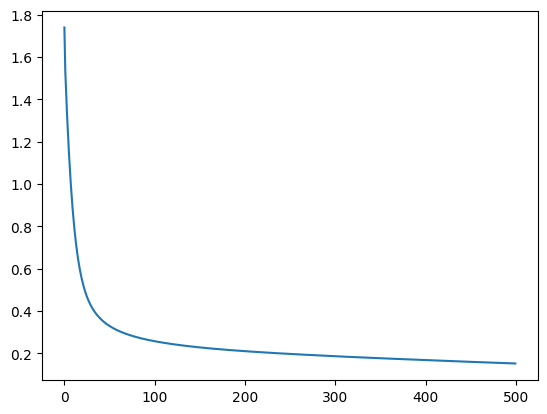

In [ ]:
plt.plot(loss_list)
print(loss_list[-1])

In [ ]:
# Inference
y_preds = X_test @ w1 + b1

h1 = relu(y_preds)

y_preds = h1 @ w2 + b2

# Softmax application
logit_max = y_preds.max(dim=1, keepdim=True).values
logit_new = y_preds - logit_max
logit_exp = logit_new.exp()
logit_exp_sum = logit_exp.sum(dim=1, keepdim=True)
logit_exp_sum_inv = logit_exp_sum ** (-1)
probs = logit_exp * logit_exp_sum_inv

# Predicted class = argmax of probabilities
pred_labels = probs.argmax(dim=1)
print(pred_labels[:10])
print(y_test[:10])

correct_predictions = (y_test == pred_labels).sum()
total_samples = y_test.shape[0]
accuracy = correct_predictions.item() / total_samples

print("Correct Predictions:", correct_predictions.item(),"out of", total_samples)
print(f"Accuracy: {accuracy:.4f}")

tensor([0, 2, 4, 4, 3, 2, 0, 3, 1, 4])
tensor([4, 2, 4, 4, 3, 2, 0, 3, 1, 4])
Correct Predictions: 1399 out of 1500
Accuracy: 0.9327
